In [1]:
%cd /proj/azizpour-group/users/x_amime/projects/an_explanation_model

/proj/azizpour-group/users/x_amime/projects/an_explanation_model


/home/x_amime/.conda/envs/xlab/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from functools import partial

from source.project_manager import (
    load_experiment_inconsistency,
    load_experiment_metadata,
    delete_experiment_data,
    check_file_exists,
)
from commands.experiment_6_1 import (
    save_metadata_dir,
    dataset_dir,
    input_shape,
    save_output_dir,
)

os.makedirs(save_output_dir, exist_ok=True)
from source.data_manager import (
    preprocess_masks,
    plot_masks,
    minmax_normalize,
    sum_channels,
    symmetric_minmax_normalize,
    single_query_imagenet,
    save_axis,
)
from source.labels import IMAGENET_LABELS

imshow_args = {"cmap": "jet"}

query_imagenet = partial(
    single_query_imagenet, dataset_dir=dataset_dir, input_shape=input_shape
)

2024-01-23 12:34:30.787349: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-23 12:34:31.806462: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/x_amime/.conda/envs/xlab/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
project_metadata = load_experiment_metadata(save_metadata_dir)
print(project_metadata.columns)
project_metadata = project_metadata.set_index(
    [
        "stream_name",
        "stream_statistic",
        "image_index",
        "baseline_mask_type",
        "alpha_mask_value",
    ]
).sort_index()
print(project_metadata.shape)
project_metadata.drop_duplicates(inplace=True)

Index(['time_to_compute', 'batch_index', 'monitored_statistic_change',
       'path_prefix', 'data_path', 'stream_name', 'stream_statistic',
       'alpha_mask_type', 'alpha_mask_value', 'baseline_mask_type',
       'projection_type', 'projection_distribution', 'projection_top_k',
       'projection_index', 'label', 'architecture', 'method', 'output_layer',
       'dataset', 'image_index', 'image_path', 'input_shape', 'num_classes',
       'seed', 'batch_size', 'max_batches', 'min_change',
       'metadata_file_path'],
      dtype='object')
(2013, 23)


In [4]:
vc = project_metadata.index.value_counts()
print(vc)
print(len(vc))
image_indices = project_metadata.index.get_level_values("image_index").unique()
image_indices = [0]

stream_name            stream_statistic  image_index  baseline_mask_type  alpha_mask_value
log_probs              meanx             0            gaussian            0.00                1
results_at_projection  meanx             1000         gaussian            0.57                1
vanilla_grad_mask      meanx2            0            gaussian            0.09                1
                                                                          0.08                1
                                                                          0.07                1
                                                                                             ..
log_probs              meanx             1000         gaussian            0.56                1
                                                                          0.55                1
                                                                          0.54                1
                                             

In [5]:
for name in project_metadata.index.names:
    print(
        name,
        "=",
        project_metadata.index.get_level_values(name).value_counts().to_dict(),
    )

stream_name = {'log_probs': 671, 'results_at_projection': 671, 'vanilla_grad_mask': 671}
stream_statistic = {'meanx': 1342, 'meanx2': 671}
image_index = {0: 183, 100: 183, 200: 183, 300: 183, 400: 183, 500: 183, 600: 183, 700: 183, 800: 183, 900: 183, 1000: 183}
baseline_mask_type = {'gaussian': 2013}
alpha_mask_value = {0.0: 33, 0.31: 33, 0.33: 33, 0.34: 33, 0.35: 33, 0.36: 33, 0.37: 33, 0.38: 33, 0.39: 33, 0.4: 33, 0.41: 33, 0.42: 33, 0.43: 33, 0.44: 33, 0.45: 33, 0.46: 33, 0.47: 33, 0.48: 33, 0.49: 33, 0.5: 33, 0.51: 33, 0.52: 33, 0.53: 33, 0.54: 33, 0.55: 33, 0.56: 33, 0.5700000000000001: 33, 0.58: 33, 0.59: 33, 0.32: 33, 0.3: 33, 0.01: 33, 0.29: 33, 0.02: 33, 0.03: 33, 0.04: 33, 0.05: 33, 0.06: 33, 0.07: 33, 0.08: 33, 0.09: 33, 0.1: 33, 0.11: 33, 0.12: 33, 0.13: 33, 0.14: 33, 0.15: 33, 0.16: 33, 0.17: 33, 0.18: 33, 0.19: 33, 0.2: 33, 0.21: 33, 0.22: 33, 0.23: 33, 0.24: 33, 0.25: 33, 0.26: 33, 0.27: 33, 0.28: 33, 0.6: 33}


In [6]:
import functools


def spectral_lens_argmax(data):
    grad_max = np.load(data.iloc[0]["grad_mask"])
    grad_max = sum_channels(grad_max)
    grad_argmax = np.ones_like(grad_max) * -1
    for id, row in data.iterrows():
        temp_grad = np.load(row["grad_mask"])
        temp_grad = sum_channels(temp_grad)
        grad_max_id = temp_grad > grad_max
        grad_argmax[grad_max_id] = row["alpha_mask_value"]
        grad_max = np.maximum(grad_max, temp_grad)

    assert (grad_argmax > -1).all()

    assert grad_argmax.ndim == 3, f"{grad_argmax.shape} must be 4d (H,W,C)"
    return grad_argmax

def preprocess_masks_ndarray(masks, preprocesses):
    for preprocess in preprocesses:
        masks = preprocess(masks)
    return masks

def spectral_lens_generic(data, func, perprocess):
    init_val = np.load(data.iloc[0]["grad_mask"])
    init_val = preprocess_masks_ndarray(init_val, preprocesses=perprocess)

    for id, row in data.iterrows():
        temp_grad = np.load(row["grad_mask"])
        temp_grad = preprocess_masks_ndarray(temp_grad, preprocesses=perprocess)
        init_val = func(init_val, temp_grad)

    assert init_val.ndim == 3, f"{init_val.shape} must be 4d (H,W,C)"

    return init_val


def spectral_lens_max(data):
    grad_max = spectral_lens_generic(data, np.maximum, [sum_channels])
    return grad_max


def running_sum(init_val, temp_grad):
    return init_val + temp_grad


def div_by_sum(grad_mask, grad_sum):
    return grad_mask / grad_sum


def spectral_lens_negentropy(data):
    def running_negentropy(init_val, temp_grad):
        return init_val + temp_grad * np.log(temp_grad)

    grad_sum = spectral_lens_generic(data, running_sum, [sum_channels])
    div_by_sum_internal = functools.partial(div_by_sum, grad_sum=grad_sum)
    grad_negentropy = spectral_lens_generic(
        data, running_negentropy, [sum_channels, div_by_sum_internal]
    )

    assert grad_negentropy.ndim == 3, f"{grad_negentropy.shape} must be 4d (H,W,C)"
    grad_negentropy = np.expand_dims(grad_negentropy, axis=0)
    return -grad_negentropy


def spectral_lens_sum(data):
    grad_sum = spectral_lens_generic(data, running_sum, [sum_channels])
    grad_sum = np.expand_dims(grad_sum, axis=0)
    return grad_sum


def spectral_lens_mean_freq(data):
    def func(init_val, temp_grad, frequency):
        return init_val + temp_grad * (frequency**(3/2)/(1-frequency))

    grad_sum = spectral_lens_generic(data, running_sum, [sum_channels])
    div_by_sum_internal = functools.partial(div_by_sum, grad_sum=grad_sum)
    perprocess = [sum_channels, div_by_sum_internal]

    init_val = np.load(data.iloc[0]["grad_mask"])
    init_val = np.zeros_like(sum_channels(init_val))

    for id, row in data.iterrows():
        temp_grad = np.load(row["grad_mask"])
        temp_grad = preprocess_masks_ndarray(temp_grad, preprocesses=perprocess)
        init_val = func(init_val, temp_grad, row["alpha_mask_value"])

    assert init_val.ndim == 3, f"{init_val.shape} must be 4d (H,W,C)"
    init_val = np.expand_dims(init_val, axis=0)
    return init_val


def spectral_lens_negvar(data):
    grad_mean = spectral_lens_generic(data, running_sum, [sum_channels])
    grad_var = spectral_lens_generic(
        data, running_sum, [sum_channels, lambda x: x**2]
    )
    grad_mean = grad_mean / len(data)
    grad_var = grad_var / len(data) - grad_mean**2
    grad_var = np.expand_dims(grad_var, axis=0)
    return grad_var

In [7]:
explanations_temp = project_metadata.loc[
    ("vanilla_grad_mask", "meanx2", image_indices, "gaussian", slice(None)), "data_path"
]
explanations_temp = explanations_temp.droplevel(
    ["stream_name", "stream_statistic", "baseline_mask_type"]
)
explanations_temp.name = "grad_mask"
explanations_temp.sort_index(inplace=True)
explanations_temp = explanations_temp.reset_index()
# explanations_argmax = explanations_temp.groupby("image_index", as_index=False).apply(
#     spectral_lens_argmax
# )
# explanations_max = explanations_temp.groupby("image_index",as_index=False).apply(spectral_lens_max)
# explanations_negentropy = explanations_temp.groupby(
#     "image_index", as_index=False
# ).apply(spectral_lens_negentropy)
# explanations_mean = explanations_temp.groupby("image_index",as_index=False).apply(spectral_lens_mean)
# explanations_negvar = explanations_temp.groupby("image_index",as_index=False).apply(spectral_lens_negvar)
# explanations_sum = explanations_temp.groupby("image_index", as_index=False).apply(A
#     spectral_lens_sum
# )

explanations_mean_freq = explanations_temp.groupby(
    "image_index", as_index=False
).apply(spectral_lens_mean_freq)

2024-01-23 09:11:07.635457: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-01-23:09:11:07,786 WARNING  [xla_bridge.py:617] No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


2024-01-23 09:11:18.564353: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-01-23 09:11:18.565136: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: berzelius1.nsc.liu.se
2024-01-23 09:11:18.565146: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: berzelius1.nsc.liu.se
2024-01-23 09:11:18.566790: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 525.147.5
2024-01-23 09:11:18.567127: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 525.147.5
2024-01-23 09:11:18.567135: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 525.147.5
2024-01-23 09:11:18.970352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start 

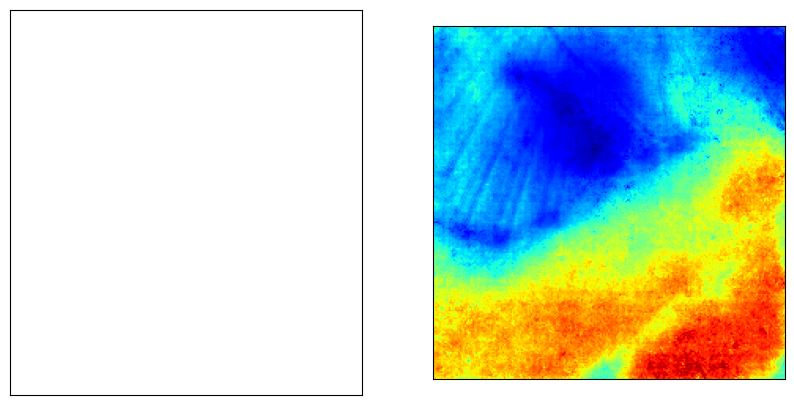

In [8]:
n_cols = 2
n_rows = len(image_indices)
fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(5 * n_cols, 5 * n_rows),
)
axes = axes.flatten()
i = 0
names = []
for image_index, explanation_mean_freq in zip(image_indices, explanations_mean_freq):
    if i >= axes.size:
        break
    original_image, label, image_path = query_imagenet(image_index=image_index)

    # axes[i].imshow(np.squeeze(original_image))
    clean_label = IMAGENET_LABELS[label]
    clean_label = clean_label.split(",")[0]
    # axes[i].set_title(f"label: {clean_label}")
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    # names.append(f"image_index {image_index} original image ({clean_label})")
    explanation_mean_freq = minmax_normalize(explanation_mean_freq)
    im_out = axes[i + 1].imshow(explanation_mean_freq.squeeze(), cmap="jet")
    # axes[i + 1].set_title("mean frequency")
    axes[i + 1].set_xticks([])
    axes[i + 1].set_yticks([])
    names.append(f"image_index {image_index} mean frequency ({clean_label})")

    # explanation_negentropy = minmax_normalize(explanation_negentropy)
    # axes[i+2].imshow(explanation_negentropy.squeeze(), cmap="jet")
    # axes[i+2].set_title("negative entropy")
    # names.append(f"image_index {image_index} negative entropy")

    i += 2

save_axis(names=names, fig=fig, axes=axes, save_output_dir=save_output_dir)

2024-01-19 09:54:11.995390: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-01-19:09:54:12,008 WARNING  [xla_bridge.py:617] No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


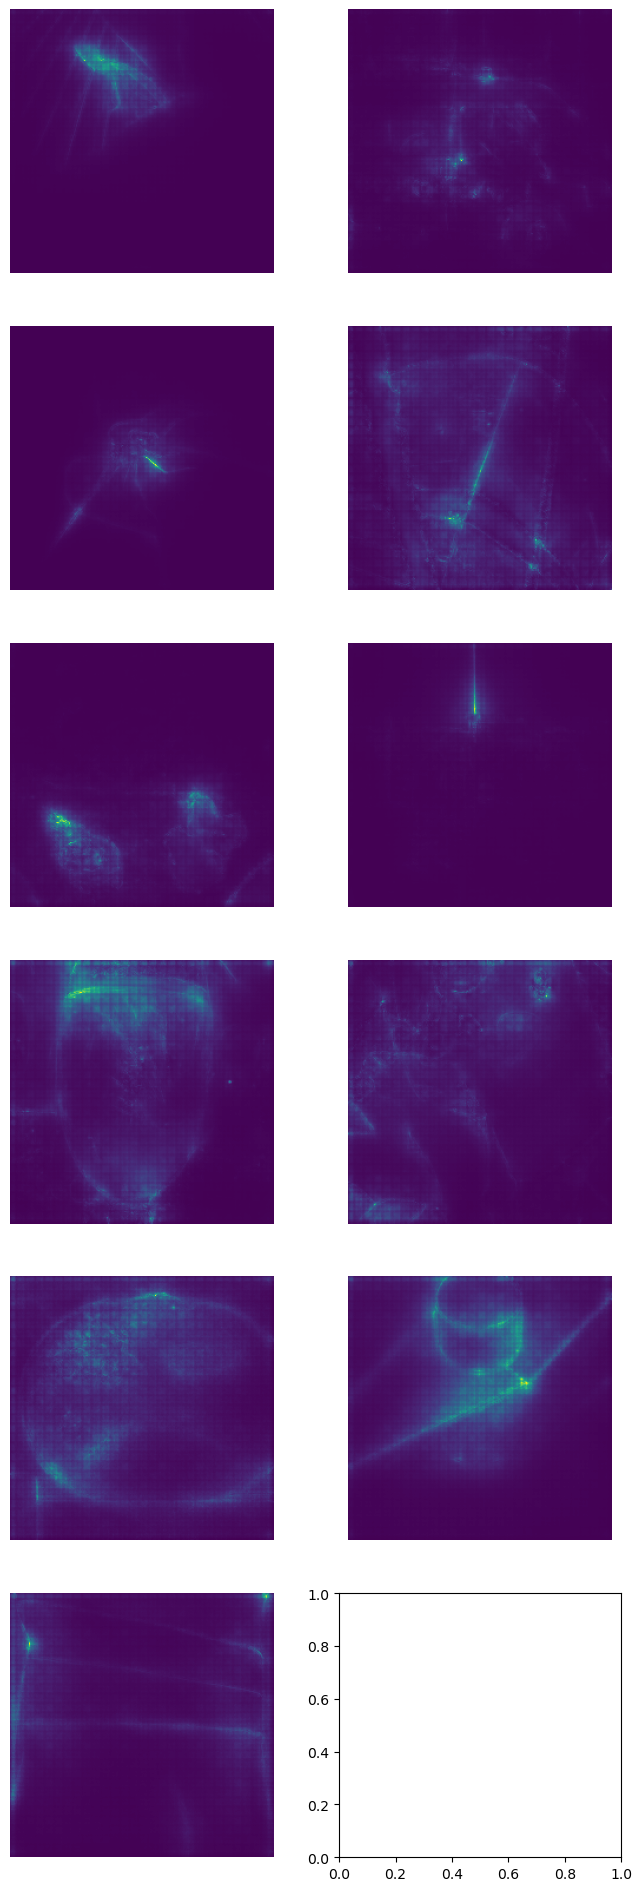

In [8]:
temp_masks = explanations_temp.set_index(["image_index", "alpha_mask_value"])
temp_masks = temp_masks.loc[(slice(None), 0.2),"grad_mask"]
titles = temp_masks.index.to_series().apply(lambda x: f"image_index {x[0]} alpha {x[1]:.2f}")
temp_masks=temp_masks.apply(np.load)
temp_masks = preprocess_masks(temp_masks, preprocesses=[sum_channels, minmax_normalize])
imshow_args = {"cmap": "viridis"}
fig, axes = plot_masks(temp_masks, imshow_args=imshow_args, ncols=2)
save_axis(titles, fig, axes, save_output_dir)

In [13]:
image_index = 0
original_image, label, image_path = query_imagenet(image_index=image_index)

2024-01-23 12:36:15.914432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [50000]
	 [[{{node Placeholder/_1}}]]
2024-01-23 12:36:15.914726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [50000]
	 [[{{node Placeholder/_1}}]]


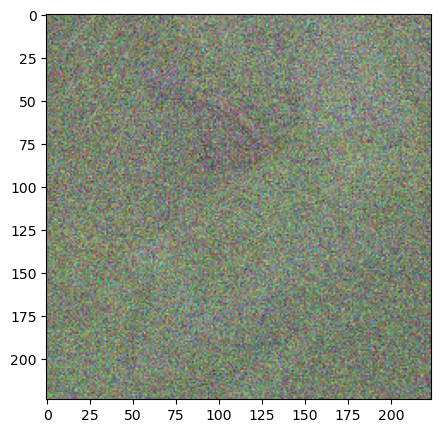

In [18]:
temp = original_image.copy()
for i in range(5):
    noise = np.random.randn(*original_image.shape)*0.1
    temp = temp + noise
    # normalize between 0 and 1
    temp = minmax_normalize(temp)

# show the image
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
axes.imshow(temp.squeeze())